# Image Captioning with Attention

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import image

import itertools

tf.random.set_seed(1)


Loading the Data. The data consist of pictures and labels of linear functions

In [3]:
import cv2
import os

def load_images_from_folder(folder, n_imgs=-1):
    images = []
    image_nums = []
    for filename in os.listdir(folder)[:n_imgs]:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            image_nums.append(filename.strip('.png'))
    return images, image_nums

folder="../../linear_fcns/images"

In [4]:
images, fnames = load_images_from_folder(folder)

In [5]:
labels = pd.read_csv('../../linear_fcns/data.csv')

In [6]:
labels['img_number'] = labels['filename'].apply(lambda x: x.split('/')[-1].strip('.png'))

In [7]:
labels.head()

,latex,filename,img_number
0,0a+1=2,linear_fcns/images/0.png,0
1,0b+1=2,linear_fcns/images/1.png,1
2,0c+1=2,linear_fcns/images/2.png,2
3,0d+1=2,linear_fcns/images/3.png,3
4,0e+1=2,linear_fcns/images/4.png,4


In [8]:
label_array = labels[labels['img_number'].isin(fnames)]['latex'].values

In [9]:
label_array

array(['0a+1=2', '0b+1=2', '0c+1=2', ..., '9x+8=7', '9y+8=7', '9z+8=7'],
      dtype=object)

For the labels we need to add start and end tokens so the model can recognize what to write.

In [10]:
label_array = [f'\t{la}\n' for la in label_array]

Let's reshape the images so we can plot them.

In [11]:
images = np.array(images)
images = 255 - images
# images = tf.image.rgb_to_grayscale(images)
images = np.array(images)
images.shape

(18719, 72, 360, 3)

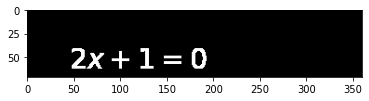

In [12]:
plt.imshow(images[0].squeeze())

Now we can process them and prepare them for inceptionv3 which is transfer learning

In [13]:
img_mini = tf.image.resize_with_pad(images, 299, 299)
img_mini = tf.keras.applications.inception_v3.preprocess_input(img_mini)

In [14]:
test_img = img_mini[2222]

Now we can load the features of the inceptionv3 model as seen below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


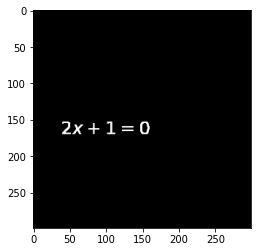

In [15]:
plt.imshow(tf.squeeze(img_mini[0]))

In [16]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [17]:
import time



# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices((img_mini, label_array)).batch(300)
c = 1

for img, label in image_dataset:
    start = time.time()
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
    p = f'Batch Features/batch_features{c}'
    c = c+1 
     #path_of_feature = p.numpy().decode("utf-8")
    end_process = time.time()
    np.save(p, batch_features)
    end_save = time.time()
    print(end_process - start)
    print(end_save - start)
    print(end_save-end_process)

50.72460103034973
51.30096983909607
0.5763688087463379
32.94227910041809
33.442338943481445
0.5000598430633545
31.193147897720337
31.715389013290405
0.5222411155700684
31.30634117126465
31.833388090133667
0.5270469188690186
33.8474280834198
34.46813416481018
0.6207060813903809
38.175379276275635
38.81036639213562
0.6349871158599854
54.89798927307129
55.9008252620697
1.002835988998413
43.53984880447388
44.42450976371765
0.8846609592437744
44.18565392494202
44.76571202278137
0.5800580978393555
43.511730909347534
44.17490100860596
0.6631700992584229
42.181363105773926
42.75337815284729
0.5720150470733643
42.62173080444336
43.15097713470459
0.5292463302612305
38.34805417060852
38.88285827636719
0.534804105758667
38.540546894073486
39.252058029174805
0.7115111351013184
38.34740090370178
38.91440987586975
0.5670089721679688
42.16173696517944
42.710243225097656
0.5485062599182129
39.796581983566284
40.31315207481384
0.5165700912475586
42.389888048172
42.93109083175659
0.5412027835845947
42.17

In [17]:
img_load = np.load('Batch Features/batch_features1.npy')
for i in range(2,61):
    img_add = np.load(f'Batch Features/batch_features{i}.npy')
    img_load = np.concatenate((img_load, img_add))

In [18]:
img_load.shape

(18000, 64, 2048)

### Tokenizing the labels

Now we can pad the labels to make sure they are all the same length.

In [19]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [20]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters=' ',
                                                  char_level=True)
tokenizer.fit_on_texts(label_array)
train_seqs = tokenizer.texts_to_sequences(label_array)

# Padding
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(label_array)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [21]:
tokenizer.get_config()

{'num_words': 5000,
 'filters': ' ',
 'lower': True,
 'split': ' ',
 'char_level': True,
 'oov_token': '<unk>',
 'document_count': 18719,
 'word_counts': '{"\\t": 18719, "0": 5615, "a": 720, "+": 18719, "1": 5616, "=": 18719, "2": 5616, "\\n": 18719, "b": 720, "c": 719, "d": 720, "e": 720, "f": 720, "g": 720, "h": 720, "i": 720, "j": 720, "k": 720, "l": 720, "m": 720, "n": 720, "o": 720, "p": 720, "q": 720, "r": 720, "s": 720, "t": 720, "u": 720, "v": 720, "w": 720, "x": 720, "y": 720, "z": 720, "3": 5616, "4": 5615, "5": 5616, "6": 5616, "7": 5616, "8": 5616, "9": 5615}',
 'word_docs': '{"2": 5616, "\\n": 18719, "=": 18719, "+": 18719, "a": 720, "1": 5616, "0": 5615, "\\t": 18719, "b": 720, "c": 719, "d": 720, "e": 720, "f": 720, "g": 720, "h": 720, "i": 720, "j": 720, "k": 720, "l": 720, "m": 720, "n": 720, "o": 720, "p": 720, "q": 720, "r": 720, "s": 720, "t": 720, "u": 720, "v": 720, "w": 720, "x": 720, "y": 720, "z": 720, "3": 5616, "4": 5615, "5": 5616, "6": 5616, "7": 5616, "8":

In [22]:
max_length

8

In [23]:
print(f'{label_array[0]} -> {train_seqs[0]}')

	0a+1=2
 -> [2, 13, 16, 3, 6, 4, 7, 5]


In [24]:
import json

char_to_int_map = tokenizer.get_config()['word_index']
char_to_int_map = json.loads(char_to_int_map)
[char_to_int_map[c] for c in label_array[0]]

[2, 13, 16, 3, 6, 4, 7, 5]

### Train Test Split

This kind of makes a train test split but I don't think it is exactly what we want.

For the model

In [25]:
img_train = img_mini[:14000]
img_test = img_mini[14000:]
img_name = cap_vector[:14000]
img_name_test = cap_vector[14000:]

In [26]:
img_train.shape

TensorShape([14000, 299, 299, 3])

In [27]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 1
BUFFER_SIZE = 20
embedding_dim = 16
units = 32
vocab_size = top_k + 1
num_steps = len(img_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

## Model

Below we are defining the attention, the encoder and the decoder. The encoder is just a fully connected layer from the features already extracted.

In [28]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [29]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        #print(f'This is x: {x}')
        x = tf.nn.relu(x)
        #print(f'This is x: {x}')
        return x

In [30]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)
        #print('decoder attention complete')
        #print(x.shape)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        #print('decoder embedding complete')
        #print(f'x.shape = {x.shape}')
        #print(f'context_vector.shape = {context_vector.shape}')

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        #print('decoder embedding + context vector complete')

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        #print('decoder gru complete')

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        #print('decoder fc1 complete')

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))
        #print('decoder reshape complete')

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)
        #print('decoder fc2 complete')

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [31]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [32]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [33]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [34]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
      start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
      # restoring the latest checkpoint in checkpoint_path
      ckpt.restore(ckpt_manager.latest_checkpoint)

In [35]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [36]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

          # initializing the hidden state for each batch
          # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    #print(f'hidden complete: {hidden}')

    # Create a vector of all \t indices to indicate the start of prediction
    dec_input = tf.expand_dims([tokenizer.word_index['\t']] * target.shape[0], 1)
    #print(f'dec_input complete: {dec_input}')

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        #print('encoder complete')
        #print(f'features.shape = {features.shape}')

        # iterate through timesteps to predict the i'th character
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            #print('decoder complete')

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [37]:
new = cap_vector[:18000]

In [38]:
image_dataset_encoded = tf.data.Dataset.from_tensor_slices((img_load, new)).batch(300)

In [39]:
import time
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(image_dataset_encoded):
      #print(img_tensor.shape)
      #print(target.shape)
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 1 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save() 
    print(num_steps)
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 7.4536
Epoch 1 Batch 1 Loss 7.4470
Epoch 1 Batch 2 Loss 7.4381
Epoch 1 Batch 3 Loss 7.4222
Epoch 1 Batch 4 Loss 7.3940
Epoch 1 Batch 5 Loss 7.3611
Epoch 1 Batch 6 Loss 7.3244
Epoch 1 Batch 7 Loss 7.2860
Epoch 1 Batch 8 Loss 7.2551
Epoch 1 Batch 9 Loss 7.2027
Epoch 1 Batch 10 Loss 7.1550
Epoch 1 Batch 11 Loss 7.0977
Epoch 1 Batch 12 Loss 7.0223
Epoch 1 Batch 13 Loss 6.9588
Epoch 1 Batch 14 Loss 6.8851
Epoch 1 Batch 15 Loss 6.8163
Epoch 1 Batch 16 Loss 6.7497
Epoch 1 Batch 17 Loss 6.6726
Epoch 1 Batch 18 Loss 6.5924
Epoch 1 Batch 19 Loss 6.5223
Epoch 1 Batch 20 Loss 6.4188
Epoch 1 Batch 21 Loss 6.3362
Epoch 1 Batch 22 Loss 6.2364
Epoch 1 Batch 23 Loss 6.1236
Epoch 1 Batch 24 Loss 6.0119
Epoch 1 Batch 25 Loss 5.8862
Epoch 1 Batch 26 Loss 5.7615
Epoch 1 Batch 27 Loss 5.6131
Epoch 1 Batch 28 Loss 5.4904
Epoch 1 Batch 29 Loss 5.3399
Epoch 1 Batch 30 Loss 5.1891
Epoch 1 Batch 31 Loss 5.0223
Epoch 1 Batch 32 Loss 4.9058
Epoch 1 Batch 33 Loss 4.7327
Epoch 1 Batch 34 Loss 4.

Epoch 5 Batch 35 Loss 2.5569
Epoch 5 Batch 36 Loss 2.5289
Epoch 5 Batch 37 Loss 2.5221
Epoch 5 Batch 38 Loss 2.5172
Epoch 5 Batch 39 Loss 2.4775
Epoch 5 Batch 40 Loss 2.4739
Epoch 5 Batch 41 Loss 2.4884
Epoch 5 Batch 42 Loss 2.5219
Epoch 5 Batch 43 Loss 2.5011
Epoch 5 Batch 44 Loss 2.5069
Epoch 5 Batch 45 Loss 2.4858
Epoch 5 Batch 46 Loss 2.4410
Epoch 5 Batch 47 Loss 2.4371
Epoch 5 Batch 48 Loss 2.4558
Epoch 5 Batch 49 Loss 2.4807
Epoch 5 Batch 50 Loss 2.4904
Epoch 5 Batch 51 Loss 2.4739
Epoch 5 Batch 52 Loss 2.4509
Epoch 5 Batch 53 Loss 2.4030
Epoch 5 Batch 54 Loss 2.4022
Epoch 5 Batch 55 Loss 2.4200
Epoch 5 Batch 56 Loss 2.4620
Epoch 5 Batch 57 Loss 2.4565
Epoch 5 Batch 58 Loss 2.4328
Epoch 5 Batch 59 Loss 2.4081
14000
Epoch 5 Loss 0.010798
Time taken for 1 epoch 41.79852318763733 sec

Epoch 6 Batch 0 Loss 2.4427
Epoch 6 Batch 1 Loss 2.4159
Epoch 6 Batch 2 Loss 2.4029
Epoch 6 Batch 3 Loss 2.3647
Epoch 6 Batch 4 Loss 2.3428
Epoch 6 Batch 5 Loss 2.3415
Epoch 6 Batch 6 Loss 2.3537
Epoch

Epoch 10 Batch 7 Loss 1.5277
Epoch 10 Batch 8 Loss 1.5096
Epoch 10 Batch 9 Loss 1.5064
Epoch 10 Batch 10 Loss 1.4836
Epoch 10 Batch 11 Loss 1.4442
Epoch 10 Batch 12 Loss 1.4556
Epoch 10 Batch 13 Loss 1.4666
Epoch 10 Batch 14 Loss 1.5298
Epoch 10 Batch 15 Loss 1.5175
Epoch 10 Batch 16 Loss 1.5122
Epoch 10 Batch 17 Loss 1.4882
Epoch 10 Batch 18 Loss 1.4485
Epoch 10 Batch 19 Loss 1.4528
Epoch 10 Batch 20 Loss 1.4586
Epoch 10 Batch 21 Loss 1.5213
Epoch 10 Batch 22 Loss 1.5109
Epoch 10 Batch 23 Loss 1.4944
Epoch 10 Batch 24 Loss 1.4801
Epoch 10 Batch 25 Loss 1.4582
Epoch 10 Batch 26 Loss 1.4509
Epoch 10 Batch 27 Loss 1.4657
Epoch 10 Batch 28 Loss 1.5247
Epoch 10 Batch 29 Loss 1.5110
Epoch 10 Batch 30 Loss 1.4911
Epoch 10 Batch 31 Loss 1.4942
Epoch 10 Batch 32 Loss 1.4604
Epoch 10 Batch 33 Loss 1.4506
Epoch 10 Batch 34 Loss 1.4643
Epoch 10 Batch 35 Loss 1.5139
Epoch 10 Batch 36 Loss 1.5025
Epoch 10 Batch 37 Loss 1.5005
Epoch 10 Batch 38 Loss 1.5103
Epoch 10 Batch 39 Loss 1.4598
Epoch 10 Batc

Epoch 14 Batch 32 Loss 1.4407
Epoch 14 Batch 33 Loss 1.4379
Epoch 14 Batch 34 Loss 1.4512
Epoch 14 Batch 35 Loss 1.4907
Epoch 14 Batch 36 Loss 1.4807
Epoch 14 Batch 37 Loss 1.4761
Epoch 14 Batch 38 Loss 1.4817
Epoch 14 Batch 39 Loss 1.4384
Epoch 14 Batch 40 Loss 1.4392
Epoch 14 Batch 41 Loss 1.4516
Epoch 14 Batch 42 Loss 1.4858
Epoch 14 Batch 43 Loss 1.4770
Epoch 14 Batch 44 Loss 1.4880
Epoch 14 Batch 45 Loss 1.4725
Epoch 14 Batch 46 Loss 1.4343
Epoch 14 Batch 47 Loss 1.4319
Epoch 14 Batch 48 Loss 1.4465
Epoch 14 Batch 49 Loss 1.4694
Epoch 14 Batch 50 Loss 1.5014
Epoch 14 Batch 51 Loss 1.4876
Epoch 14 Batch 52 Loss 1.4776
Epoch 14 Batch 53 Loss 1.4434
Epoch 14 Batch 54 Loss 1.4342
Epoch 14 Batch 55 Loss 1.4456
Epoch 14 Batch 56 Loss 1.5095
Epoch 14 Batch 57 Loss 1.5210
Epoch 14 Batch 58 Loss 1.5044
Epoch 14 Batch 59 Loss 1.5039
14000
Epoch 14 Loss 0.006307
Time taken for 1 epoch 39.94004201889038 sec

Epoch 15 Batch 0 Loss 1.5153
Epoch 15 Batch 1 Loss 1.5011
Epoch 15 Batch 2 Loss 1.507

Epoch 18 Batch 57 Loss 1.5276
Epoch 18 Batch 58 Loss 1.5108
Epoch 18 Batch 59 Loss 1.5001
14000
Epoch 18 Loss 0.006296
Time taken for 1 epoch 40.11274480819702 sec

Epoch 19 Batch 0 Loss 1.5070
Epoch 19 Batch 1 Loss 1.4874
Epoch 19 Batch 2 Loss 1.4843
Epoch 19 Batch 3 Loss 1.4590
Epoch 19 Batch 4 Loss 1.4424
Epoch 19 Batch 5 Loss 1.4394
Epoch 19 Batch 6 Loss 1.4561
Epoch 19 Batch 7 Loss 1.4940
Epoch 19 Batch 8 Loss 1.4784
Epoch 19 Batch 9 Loss 1.4756
Epoch 19 Batch 10 Loss 1.4587
Epoch 19 Batch 11 Loss 1.4341
Epoch 19 Batch 12 Loss 1.4405
Epoch 19 Batch 13 Loss 1.4573
Epoch 19 Batch 14 Loss 1.4970
Epoch 19 Batch 15 Loss 1.4852
Epoch 19 Batch 16 Loss 1.4818
Epoch 19 Batch 17 Loss 1.4643
Epoch 19 Batch 18 Loss 1.4376
Epoch 19 Batch 19 Loss 1.4389
Epoch 19 Batch 20 Loss 1.4514
Epoch 19 Batch 21 Loss 1.4950
Epoch 19 Batch 22 Loss 1.4841
Epoch 19 Batch 23 Loss 1.4728
Epoch 19 Batch 24 Loss 1.4550
Epoch 19 Batch 25 Loss 1.4415
Epoch 19 Batch 26 Loss 1.4424
Epoch 19 Batch 27 Loss 1.4561
Epoch

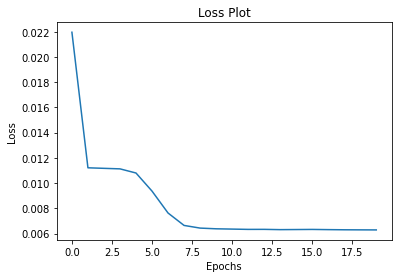

In [40]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Evaluate

In [47]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(image, 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['\t']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.random.categorical(predictions, 1)[0][0]
        predicted_id = int(predicted_id)
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '\n':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [48]:
test_img = img_mini[16000]

In [49]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(image)

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show();

Run attention_plot to see what it looks like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction Caption: 2 y + 2 



ValueError: num must be 1 <= num <= 4, not 5

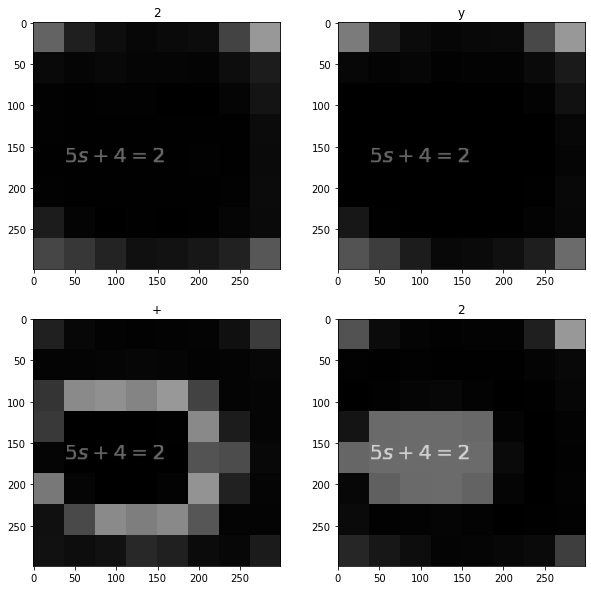

In [50]:
result, attention_plot = evaluate(test_img)
print ('Prediction Caption:', ' '.join(result))
plot_attention(test_img, result, attention_plot)
# opening the image
plt.imshow(test_img)